In [1]:
%run -i 'src/SPV.py'
from src.data_functions import *
from src.solution_algorithms import *

## Load Generation, Demand and Prices Data

In [2]:
df = pd.read_csv('data/full_randomized_2017_hourly_normalized_v2.csv') #Load demand and solar generation per kW dataframe
df2 = pd.read_csv('data/LMP_2017_data.csv') #Load wholesale prices data

## Obtain lists, matrices and arrays from dataframes

In [3]:
dataids = obtain_dataid_2017(df) #list of dataids of firms
dataids_array = np.asarray(dataids) #numpy array of dataids 
validdata = len(dataids) #Total of firms
T = len(df[df.dataid==26].use.values) #Total of time slots
localtime_data = df[df.dataid==26].localhour #Hour data of time slots

In [4]:
gen_kw = f_gen_per_kw(df) #Matrix of normalized solar generation: Rows are timeslots and columns are firms
load_kw = f_load_kw(df) #Matrix of load: Rows are timeslots and columns are firms

1 m$^2$ is 1550 in$^2$

Typical size of solar panel: is 65 in for 39 in = 2535 in$^2$ = 1.6354 m$^2$.

The rated power of a solar panel is typically between 250 to 350W.

To convert we use: gen_per_kw by 0.3 / 1.6354 to get gen_per_m$^2$.

In [5]:
gen_per_m2 = gen_kw*0.3/1.6354

In [6]:
#Investment per m2 is 512.2 $/m2.
#Using an anualized cost with discount rate r=5%, we obtain
CostPVperM2 = 512.2
r = 0.05
years = 20
annuity = CostPVperM2*r/(1-(1+r)**(-years)) #Obtain Annuity 
pi_s = annuity/T #Obtain cost per time step
print('Cost of PV per time step: ' + str(pi_s))

Cost of PV per time step: 0.004695025492240356


In [7]:
firms = validdata #Number of firms
gamma = 1 #Factor of NM price
pi_r = 0.18   #Retail Price at 18 cents per kWh.
pi_nm = gamma*pi_r  #Net Metering Price
a_cap_firms = f_cap_firms(gen_per_m2, load_kw) #Cap for firms to not be net producers

In [8]:
pi_g = f_lmp_prices(df2) #Obtain wholesale market prices: Data is in $/MWh
pi_g = pi_g/1000 # convert to $/kWh

## Run Case 1: Limited maximum panel area

In [14]:
a_max_firms = 0.2*a_cap_firms
pv_changes = []
gamma = np.linspace(0,1,21)
#gamma = [0.9]

#Run the sharing case (that is not affected by gamma)
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r) #Obtain the set of firms that invest
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms) #Obtain the investment decision of all firms

for g in gamma:
    pi_nm = g*pi_r
    %run -i 'src/Case_01.py'
    pv_changes.append(aux)
    clear_output()

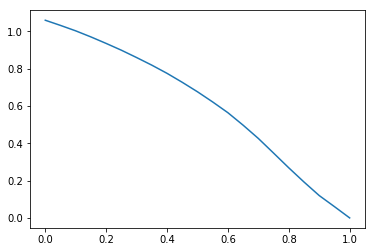

In [14]:
#Plot pv changes between standalone and sharing case
plt.plot(gamma, pv_changes)

In [ ]:
investment_standalone = solve_standalone(gen_per_m2, load_kw, dataids, a_max_firms, pi_s, pi_r, pi_nm)

In [ ]:
print('\n')
print('Investment decisions:')
print(investment_standalone) #Print investment decisions
print('\n')
print('Percentage of investment per firm (with respect to max_cap)')
print(1-(a_max_firms - investment_standalone)/a_max_firms) #Print percentage of investment of available max cap
print('\n Total Investment of PV in standalone case is '+ str(sum(investment_standalone)) + ' in m2 \n')

In [ ]:
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r)
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms)

## Run Case 3: Effect of demand charge in wholesale market prices

In [72]:
a_max_firms = 2*a_cap_firms
pi_s_array = np.linspace(0.08, 0.2, 30)*pi_s

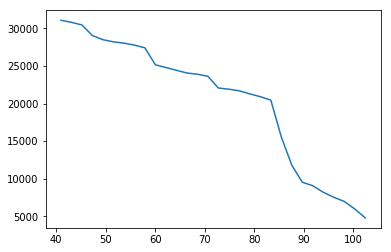

In [73]:
pi_g2 = pi_g

#pi_s_array = np.asarray([0.15*pi_s])
sol_wholesale_list_dcharge = []
for pi_s2 in pi_s_array:
    soluc_wholesale = solve_wholesale_aggregator_demandcharge(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2, 0.01)
    sol_wholesale_list_dcharge.append(np.sum(soluc_wholesale))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T
plt.plot(levelized_cost_array, sol_wholesale_list_dcharge)

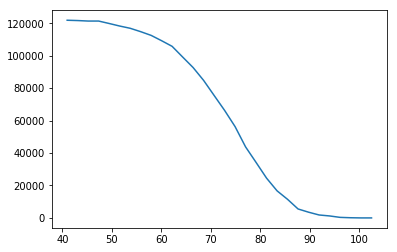

In [74]:
sol_wholesale_list = []
for pi_s2 in pi_s_array:
    soluc_wholesale = solve_wholesale_aggregator(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2)
    sol_wholesale_list.append(np.sum(soluc_wholesale))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T
plt.plot(levelized_cost_array, sol_wholesale_list)

In [77]:
print(levelized_cost_array)

[ 40.976       43.09544828  45.21489655  47.33434483  49.4537931
  51.57324138  53.69268966  55.81213793  57.93158621  60.05103448
  62.17048276  64.28993103  66.40937931  68.52882759  70.64827586
  72.76772414  74.88717241  77.00662069  79.12606897  81.24551724
  83.36496552  85.48441379  87.60386207  89.72331034  91.84275862
  93.9622069   96.08165517  98.20110345 100.32055172 102.44      ]


In [69]:
sum(a_max_firms)

122300.40004407866

In [13]:
def wholesale_energy_costs(gen_per_m2,  load_kw, a_inv, pi_g):
    load_cost_matrix = (load_kw.T * pi_g).T #define a matrix of size (8754, 1000) that contains the cost of purchasing electricity
    gen_profit_matrix = (gen_per_m2.T * pi_g).T #define a matrix of size (8754, 1000) that contains the cost of selling electricity per m2
    energy_cost = np.sum(load_cost_matrix)/T - np.sum(a_inv*np.sum(gen_profit_matrix,axis=0))/T
    return energy_cost

In [70]:
def wholesale_demand_charge_costs(gen_per_m2, load_kw, a_inv, demand_charge):
    #obtain timeseries for each month
    load_jan = load_kw[0:24*31, :]
    gen_jan = gen_per_m2[0:24*31, :]
    load_feb =  load_kw[24*31:24*59, :]
    gen_feb = gen_per_m2[24*31:24*59, :]
    load_mar = load_kw[24*59:24*90, :]
    gen_mar = gen_per_m2[24*59:24*90, :]
    load_apr = load_kw[24*90:24*120 , :]
    gen_apr = gen_per_m2[24*90:24*120 , :]
    load_may = load_kw[24*120:24*151 , :]
    gen_may = gen_per_m2[24*120:24*151 , :]
    load_jun = load_kw[24*151:24*181 , :]
    gen_jun = gen_per_m2[24*151:24*181 , :]
    load_jul = load_kw[24*181:24*212 , :]
    gen_jul = gen_per_m2[24*181:24*212 , :]
    load_aug = load_kw[24*212:24*243 , :]
    gen_aug = gen_per_m2[24*212:24*243 , :]
    load_sep = load_kw[24*243:24*273 , :]
    gen_sep = gen_per_m2[24*243:24*273 , :]
    load_oct = load_kw[24*273:24*304 , :]
    gen_oct = gen_per_m2[24*273:24*304 , :]
    load_nov = load_kw[24*304:24*334 , :]
    gen_nov = gen_per_m2[24*304:24*334 , :]
    load_dec = load_kw[24*334: , :]
    gen_dec = gen_per_m2[24*334: , :]
    
    d_charge = demand_charge/12  #average monthly payment 
    demand_costs = []
    cost_jan = d_charge* LA.norm(np.sum(load_jan,axis=1) - np.matmul(gen_jan,a_inv), np.inf)
    cost_feb = d_charge* LA.norm(np.sum(load_feb,axis=1) - np.matmul(gen_feb,a_inv), np.inf)
    cost_mar = d_charge* LA.norm(np.sum(load_mar,axis=1) - np.matmul(gen_mar,a_inv), np.inf)
    cost_apr = d_charge* LA.norm(np.sum(load_apr,axis=1) - np.matmul(gen_apr,a_inv), np.inf)
    cost_may = d_charge* LA.norm(np.sum(load_may,axis=1) - np.matmul(gen_may,a_inv), np.inf)
    cost_jun = d_charge* LA.norm(np.sum(load_jun,axis=1) - np.matmul(gen_jun,a_inv), np.inf)
    cost_jul = d_charge* LA.norm(np.sum(load_jul,axis=1) - np.matmul(gen_jul,a_inv), np.inf)
    cost_aug = d_charge* LA.norm(np.sum(load_aug,axis=1) - np.matmul(gen_aug,a_inv), np.inf)
    cost_sep = d_charge* LA.norm(np.sum(load_sep,axis=1) - np.matmul(gen_sep,a_inv), np.inf)
    cost_oct = d_charge* LA.norm(np.sum(load_oct,axis=1) - np.matmul(gen_oct,a_inv), np.inf)
    cost_nov = d_charge* LA.norm(np.sum(load_nov,axis=1) - np.matmul(gen_nov,a_inv), np.inf)
    cost_dec = d_charge* LA.norm(np.sum(load_dec,axis=1) - np.matmul(gen_dec,a_inv), np.inf)
    demand_costs.append(cost_jan)
    demand_costs.append(cost_feb)
    demand_costs.append(cost_mar)
    demand_costs.append(cost_apr)
    demand_costs.append(cost_may)
    demand_costs.append(cost_jun)
    demand_costs.append(cost_jul)
    demand_costs.append(cost_aug)
    demand_costs.append(cost_sep)
    demand_costs.append(cost_oct)
    demand_costs.append(cost_nov)
    demand_costs.append(cost_dec)
    return demand_costs

In [62]:
e_cost = wholesale_energy_costs(gen_per_m2,  load_kw, soluc_wholesale, pi_g)
print(e_cost)
e_cost = wholesale_energy_costs(gen_per_m2,  load_kw, 0, pi_g)
print(e_cost)
print(0.15*pi_s*np.sum(soluc_wholesale))

29.46261390848926
46.49627836971733
15.294402282623977


In [71]:
d_cost = wholesale_demand_charge_costs(gen_per_m2, load_kw, soluc_wholesale, 0.01)
print(np.sum(d_cost))
zero_sol = np.zeros(validdata)
d_cost = wholesale_demand_charge_costs(gen_per_m2, load_kw, zero_sol, 0.01)
print(np.sum(d_cost))

26.35079425919462
28.05626310380096


In [31]:
gen_jan = gen_per_m2[0:24*31, :]
load_jan = load_kw[0:24*31, :]

In [39]:
print(np.zeros(1000).shape)

(1000,)


In [ ]:
avg_profit_nopv = utility_profit_no_investment(load_kw, pi_r)

In [ ]:
avg_profit_standalone = utility_profit_standalone(gen_per_m2, load_kw, investment_standalone, pi_r, pi_nm)

In [ ]:
avg_profit_sharing = utility_profit_sharing(gen_per_m2, load_kw, sol_sharing, pi_r)

In [39]:
pi_s_array = np.linspace(0.1, 0.2, 11)*pi_s
print(pi_s_array)

[0.0004695  0.00051645 0.0005634  0.00061035 0.0006573  0.00070425
 0.0007512  0.00079815 0.0008451  0.00089205 0.00093901]


In [48]:
np.sum(load_kw, axis=1).size

8754

In [55]:
aux = a_max_firms*gen_per_m2

In [59]:
print(aux[10,1])
print(gen_per_m2[10,1])
print(a_max_firms[1]*gen_per_m2[10,1])

1.1510310999052593
0.03198223676164852
1.1510310999052593


In [ ]:
df3 = df2.groupby(['OPR_HR']).mean()
print(df3)

In [ ]:
df4 = df2.mean()

In [ ]:
print(df4)

In [69]:
A = np.array([[1,2],[3,4]])
b = np.array([[1,2]])
sol1 = np.dot(A,b.T)
sol2 = np.matmul(A,b.T)
print(sol1)
print(sol2)

[[ 5]
 [11]]
[[ 5]
 [11]]


In [64]:
31+28+31

90

In [84]:
localtime_data[24*334:]

8016    2017-12-01 00:00:00
8017    2017-12-01 01:00:00
8018    2017-12-01 02:00:00
8019    2017-12-01 03:00:00
8020    2017-12-01 04:00:00
8021    2017-12-01 05:00:00
8022    2017-12-01 06:00:00
8023    2017-12-01 07:00:00
8024    2017-12-01 08:00:00
8025    2017-12-01 09:00:00
8026    2017-12-01 10:00:00
8027    2017-12-01 11:00:00
8028    2017-12-01 12:00:00
8029    2017-12-01 13:00:00
8030    2017-12-01 14:00:00
8031    2017-12-01 15:00:00
8032    2017-12-01 16:00:00
8033    2017-12-01 17:00:00
8034    2017-12-01 18:00:00
8035    2017-12-01 19:00:00
8036    2017-12-01 20:00:00
8037    2017-12-01 21:00:00
8038    2017-12-01 22:00:00
8039    2017-12-01 23:00:00
8040    2017-12-02 00:00:00
8041    2017-12-02 01:00:00
8042    2017-12-02 02:00:00
8043    2017-12-02 03:00:00
8044    2017-12-02 04:00:00
8045    2017-12-02 05:00:00
               ...         
8724    2017-12-30 12:00:00
8725    2017-12-30 13:00:00
8726    2017-12-30 14:00:00
8727    2017-12-30 15:00:00
8728    2017-12-30 1

In [53]:
load_cost_matrix = (load_kw.T * pi_g).T

In [56]:
load_cost_january = load_cost_matrix[0:24*31-1, :]

In [58]:
load_cost_january.shape

(743, 1000)

In [86]:
np.max([1,2,4])

4